In [2]:
import pandas as pd

# Load CSV files
df1 = pd.read_csv("D:\\Projects\\Human-Behavior-Drift-Detection-System\\data\\Processed\\behavior_features_1.csv")
df2 = pd.read_csv("D:\\Projects\\Human-Behavior-Drift-Detection-System\\data\\Processed\\behavior_features_2.csv")
df3 = pd.read_csv("D:\\Projects\\Human-Behavior-Drift-Detection-System\\data\\Processed\\behavior_features_3.csv")
df4 = pd.read_csv("D:\\Projects\\Human-Behavior-Drift-Detection-System\\data\\Processed\\behavior_features_4.csv")

# Add video_id to each
df1["video_id"] = 1
df2["video_id"] = 2
df3["video_id"] = 3
df4["video_id"] = 4

# Combine all into one dataframe
combined_df = pd.concat([df1, df2, df3, df4], ignore_index=True)

# Save final CSV
combined_df.to_csv("D:\\Projects\\Human-Behavior-Drift-Detection-System\\data\\Processed\\combined_behavior_features.csv", index=False)

print("✅ Combined CSV saved as combined_behavior_features.csv")
print(combined_df.head())
print(combined_df.shape)


✅ Combined CSV saved as combined_behavior_features.csv
   time     speed  direction  density  direction_entropy  avg_neighbor_dist  \
0     0       NaN        NaN        2               -0.0          335.01112   
1     1  1.136316   3.002267        1               -0.0            0.00000   
2     2  3.214310  -2.883502        1               -0.0            0.00000   
3     3  3.235727   3.004949        1               -0.0            0.00000   
4     4  2.922973  -2.894376        1               -0.0            0.00000   

   video_id  
0         1  
1         1  
2         1  
3         1  
4         1  
(71921, 7)


In [3]:
import pandas as pd

df = pd.read_csv("D:\\Projects\\Human-Behavior-Drift-Detection-System\\data\\Processed\\combined_behavior_features.csv")

# remove empty rows
df = df.dropna()

features = df[[
    "speed",
    "direction",
    "density",
    "direction_entropy",
    "avg_neighbor_dist"
]]


In [4]:
df["direction_entropy"] = df["direction_entropy"].abs()


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(features)


In [6]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(
    n_estimators=200,
    contamination=0.05,
    random_state=42
)

model.fit(X)

df["anomaly"] = model.predict(X)   # -1 = drift, 1 = normal
df["anomaly_score"] = model.decision_function(X)


In [7]:
df["anomaly"] = df["anomaly"].map({1: "normal", -1: "drift"})

In [8]:
df.anomaly.value_counts()

anomaly
normal    66007
drift      3474
Name: count, dtype: int64

In [9]:
# show drift samples
df[df["anomaly"] == "drift"]

,time,speed,direction,density,direction_entropy,avg_neighbor_dist,video_id,anomaly,anomaly_score
2,2,3.214310,-2.883502,1,0.000000,0.000000,1,drift,-0.007475
3,3,3.235727,3.004949,1,0.000000,0.000000,1,drift,-0.011843
4,4,2.922973,-2.894376,1,0.000000,0.000000,1,drift,-0.005607
17,36,2.268382,-2.675093,2,0.000000,481.395836,1,drift,-0.077902
18,37,1.200057,-2.858661,2,0.693147,479.473523,1,drift,-0.020910
...,...,...,...,...,...,...,...,...,...
71359,5285,61.028027,0.053865,5,1.609438,126.209072,4,drift,-0.106264
71369,5303,18.442359,0.060379,6,1.242453,143.826541,4,drift,-0.028110
71594,5337,7.961632,-3.072539,10,1.695743,72.282069,4,drift,-0.018877
71727,5337,11.058753,-2.099368,10,1.695743,72.282069,4,drift,-0.027078


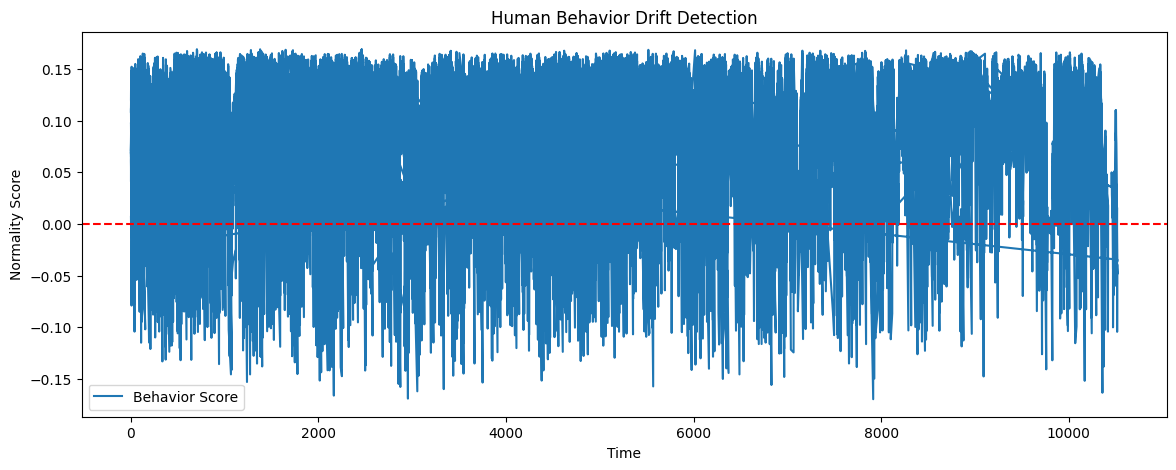

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(df["time"], df["anomaly_score"], label="Behavior Score")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Normality Score")
plt.title("Human Behavior Drift Detection")
plt.legend()
plt.show()


In [11]:
# locate drift points (time-based)
drift_mask = df["anomaly"].isin(["drift", -1])
time_col = next((c for c in ["time", "timestamp", "Time", "datetime", "date"] if c in df.columns), None)
event_col = next((c for c in ["Event_ID", "event_id", "EventId", "eventID", "id"] if c in df.columns), None)

cols = [c for c in [event_col, time_col, "anomaly_score"] if c and c in df.columns]
drift_points = df[drift_mask][cols]
if time_col:
    drift_points = drift_points.sort_values(time_col)
elif event_col:
    drift_points = drift_points.sort_values(event_col)

drift_points

,time,anomaly_score
2,2,-0.007475
3,3,-0.011843
4,4,-0.005607
37904,5,-0.005009
37036,7,-0.079147
...,...,...
36606,10516,-0.104578
36607,10517,-0.039311
36629,10517,-0.036437
36630,10518,-0.034573


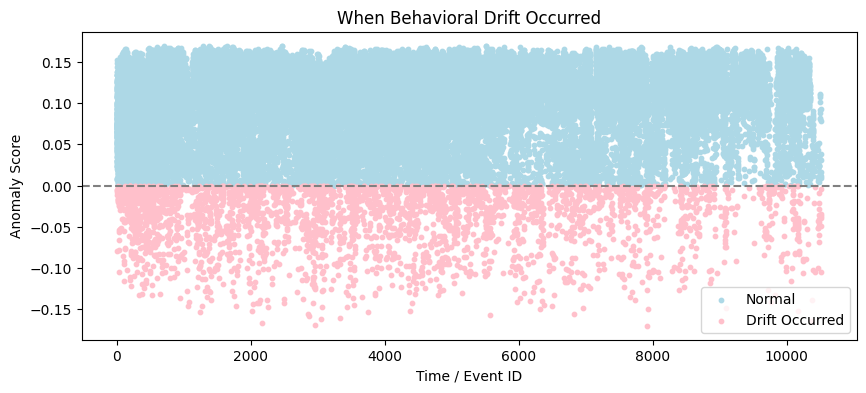

In [12]:
import matplotlib.pyplot as plt

x_col = "Event_ID" if "Event_ID" in df.columns else (time_col if "time_col" in globals() else None)
if x_col is None:
    raise ValueError("No time/Event_ID column found for plotting.")

# split normal vs drift for clearer colors
normal_mask = ~drift_mask

plt.figure(figsize=(10,4))
plt.scatter(df.loc[normal_mask, x_col], df.loc[normal_mask, "anomaly_score"],
            color="lightblue", s=10, label="Normal")
plt.scatter(df.loc[drift_mask, x_col], df.loc[drift_mask, "anomaly_score"],
color="pink", s=10, label="Drift Occurred")
plt.axhline(0, linestyle="--", color="grey")
plt.xlabel("Time / Event ID")
plt.ylabel("Anomaly Score")
plt.title("When Behavioral Drift Occurred")
plt.legend()
plt.show()

In [13]:
# compare feature means: drift vs normal
normal = df[df["anomaly"].isin(["normal", 1])]
drift = df[df["anomaly"].isin(["drift", -1])]

feature_cols = list(features.columns) if "features" in globals() else []
if not feature_cols:
    raise ValueError("Feature columns not found.")

normal_mean = normal[feature_cols].mean()
drift_mean = drift[feature_cols].mean()

diff = drift_mean - normal_mean
diff.sort_values(ascending=False)

avg_neighbor_dist    85.985955
speed                 8.883990
direction            -0.132988
direction_entropy    -0.468890
density              -1.862700
dtype: float64

In [14]:
df.to_csv("D:\\Projects\\Human-Behavior-Drift-Detection-System\\data\\Processed\\drift_detected_final.csv", index=False)

In [15]:
import pandas as pd

df = pd.read_csv("D:\\Projects\\Human-Behavior-Drift-Detection-System\\data\\Processed\\drift_detected_final.csv")

# Group drift info by video
video_groups = {
    vid: data.set_index("time")
    for vid, data in df.groupby("video_id")
}


In [18]:
import cv2
import pandas as pd

video_id = 1
video_path = "D:\\Projects\\Human-Behavior-Drift-Detection-System\\data\\raw\\crowds_zara01.avi"
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise FileNotFoundError(f"Cannot open video: {video_path}")

drift_data = video_groups[video_id]

# bbox column helpers
def pick_bbox_cols(frame):
    candidates = [
        ("x1", "y1", "x2", "y2"),
        ("xmin", "ymin", "xmax", "ymax"),
        ("left", "top", "right", "bottom"),
    ]
    for cols in candidates:
        if all(c in frame.columns for c in cols):
            return cols, "xyxy"
    wh_candidates = [
        ("x", "y", "w", "h"),
        ("cx", "cy", "w", "h"),
        ("x_center", "y_center", "width", "height"),
    ]
    for cols in wh_candidates:
        if all(c in frame.columns for c in cols):
            return cols, "xywh"
    return None, None

def draw_bbox(frame, row, bbox_cols, bbox_mode, color):
    if bbox_cols is None:
        return
    if bbox_mode == "xyxy":
        x1, y1, x2, y2 = [int(row[c]) for c in bbox_cols]
    else:
        x, y, w, h = [float(row[c]) for c in bbox_cols]
        if "cx" in bbox_cols[0] or "x_center" in bbox_cols[0]:
            x1 = int(x - w / 2)
            y1 = int(y - h / 2)
        else:
            x1 = int(x)
            y1 = int(y)
        x2 = int(x1 + w)
        y2 = int(y1 + h)
    cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)

bbox_cols, bbox_mode = pick_bbox_cols(drift_data.reset_index())
if bbox_cols is None:
    print("No bbox columns found in drift_data; only text will be shown.")

frame_id = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_id in drift_data.index:
        rows = drift_data.loc[frame_id]
        if isinstance(rows, pd.DataFrame):
            iter_rows = rows.itertuples(index=False, name=None)
            rows_df = rows
        else:
            iter_rows = [rows.values] if isinstance(rows, pd.Series) else [rows]
            rows_df = pd.DataFrame([rows]) if isinstance(rows, pd.Series) else pd.DataFrame(rows)

        # If multiple rows, draw boxes for drift rows; also show worst score label
        if isinstance(rows, pd.DataFrame):
            worst_row = rows.sort_values("anomaly_score").iloc[0]
        else:
            worst_row = rows

        score = worst_row["anomaly_score"]
        status = worst_row["anomaly"]

        if status == "drift":
            color = (0, 0, 255)  # RED
            label = f"DRIFT | Risk {abs(score):.3f}"
        else:
            color = (0, 255, 0)  # GREEN
            label = f"NORMAL | Risk {abs(score):.3f}"

        cv2.putText(
            frame,
            label,
            (30, 40),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            color,
            2
        )

        if bbox_cols is not None:
            if isinstance(rows, pd.DataFrame):
                for _, r in rows.iterrows():
                    if r["anomaly"] == "drift":
                        draw_bbox(frame, r, bbox_cols, bbox_mode, (0, 0, 255))
            else:
                if status == "drift":
                    draw_bbox(frame, rows, bbox_cols, bbox_mode, (0, 0, 255))

    cv2.imshow("Behavior Drift Detection", frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

    frame_id += 1

cap.release()
cv2.destroyAllWindows()


No bbox columns found in drift_data; only text will be shown.
